In [102]:
#Automated reloading of custom modules
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [103]:
#Standard modules
import os
import time
import numpy as np
import scipy
import torch
import random
import torch.nn as nn
from torch.utils.data import random_split, DataLoader, Dataset
import torch.nn.functional as F
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
import pandas as  pd

#Custom modules
import helpers as hlp
import models as mdl

# Check avaibale device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Used device: {}.".format(DEVICE))

Used device: cpu.


### Reproductability

In [104]:
SEED = 12345
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

### Parameters

In [105]:
#Dataset
DATASET = "MNIST" 
MODEL = "lenet5" # 'fc', 'resnet18', 'lenet5'
REDUCED = "small"
FLATTEN = True if MODEL == "fc" else False

#Learning
BATCH_SIZE = 16
EPOCHS = 100
ROUNDS = 1000
BATCH_SIZE_KD = 16
EPOCHS_PER_ROUND_KD = 1
RANDOM_SAMPLES = 1000
CRITERION = nn.CrossEntropyLoss()
CRITERION_KD = nn.MSELoss() #loss for knowledge diffusion
N_EVAL = 1 #Evaluate train and test performace after N_EVAL epochs

if False:
    #Directories
    DATE = datetime.now()
    EXPORT_DIR = "./saves/RandomKD/" + DATE.strftime("%d-%m-%Y/%H-%M-%S")
    os.makedirs(EXPORT_DIR, exist_ok=True)

    # Store parameters
    with open(EXPORT_DIR + "/metadata.txt", 'w') as f:
        f.write("Parameter of the experiment conducted the {} at {}.\n\n".format(DATE.strftime("%d/%m/%Y"),
                                                                             DATE.strftime("%H:%m:%Y")))
        f.write("Model architecture:       {}\n".format(MODEL))
        f.write("Dataset:                  {}\n".format(DATASET))
        f.write("Reduced:                  {}\n".format(REDUCED))
        f.write("Epoch (Teacher):          {}\n".format(EPOCHS))
        f.write("Batch size (Teacher):     {}\n".format(BATCH_SIZE))
        f.write("Criterion (Teacher):      {}\n".format(type(CRITERION)))
        f.write("Number of random samples: {}\n".format(RANDOM_SAMPLES))
        f.write("Rounds (KD):              {}\n".format(ROUNDS))
        f.write("Epoch per round (KD):     {}\n".format(EPOCHS_PER_ROUND_KD))
        f.write("Batch size (KD):          {}\n".format(BATCH_SIZE_KD))
        f.write("Criterion (KD):           {}\n".format(type(CRITERION_KD)))
        f.write("Seed:                     {}\n".format(SEED))

### Data loadiing

In [106]:
# Load dataset
train_input, train_target, val_input, val_target, meta = hlp.load_data(dataset=DATASET,
                                                                       reduced=REDUCED, 
                                                                       flatten=FLATTEN,
                                                                       device=DEVICE)

#Create custom torch datasets
train_ds = hlp.CustomDataset(train_input, train_target)
val_ds = hlp.CustomDataset(val_input, val_target)

#Create dataloader
train_dl = hlp.ds_to_dl(train_ds, batch_size=BATCH_SIZE)
val_dl = hlp.ds_to_dl(val_ds)
dl_dict = {"Train": train_dl, "Validation": val_dl}

** Using MNIST **
Load train data...
Load validation data...
Dataset sizes:
	- Train: (2000, 1, 28, 28)
	- Validation (500, 1, 28, 28)


## Load teacher model

In [ ]:
# Load and evaluate tacher and student model
m_, m_studentteacher = mdl.get_model(DATASET), mdl.get_model(DATASET)
m_teacher.load_state_dict(torch.load("./saves/RandomKD/Experiment0/teacher/model.pt"))
m_student.load_state_dict(torch.load("./saves/RandomKD/Experiment0/student/model.pt"))
pt_teacher = hlp.PerfTracker(m_teacher, dl_dict, CRITERION, meta["n_class"], None, ID="Teacher")
pt_student = hlp.PerfTracker(m_student, dl_dict, CRITERION, meta["n_class"], None, ID="Student")
perf_t = pt_teacher.new_eval()
perf_s = pt_student.new_eval()
print("Teacher\n-Train acc.: {}\n-Validation acc.: {}".format(perf_t["Train"]["accuracy"], perf_t["Validation"]["accuracy"]))
print("Student\n-Train acc.: {}\n-Validation acc.: {}".format(perf_s["Train"]["accuracy"], perf_s["Validation"]["accuracy"]))

Teacher
-Train acc.: 0.961
-Validation acc.: 0.94
Student
-Train acc.: 0.777
-Validation acc.: 0.734


## Train teacher model

In [14]:
# Model initialization
m_teacher = mdl.LeNet5(meta["in_dimension"][0], meta["n_class"], return_last).to(DEVICE)

# Performance tracker
pt_teacher = hlp.PerfTracker(m_teacher, dl_dict, CRITERION, meta["n_class"], None, ID="Teacher")


In [15]:
if TRAIN_TEACHER

    # Initialization
    optimizer = torch.optim.Adam(m_teacher.parameters())
    m_teacher.train()

    #Teacher learning
    for e in range(EPOCHS):
        t0 = time.time()
        for features, target in train_dl:
            optimizer.zero_grad()
            output = m_teacher(features)
            loss = CRITERION(output, target)
            loss.backward()
            optimizer.step()

        #Tracking performance
        if e % N_EVAL == 0:
            pt_teacher.new_eval(index=e)
        print("\rEpoch {}/{} done.".format(e+1, EPOCHS), end="  ")


Epoch 100/100 done.  

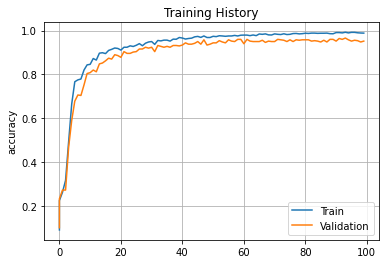

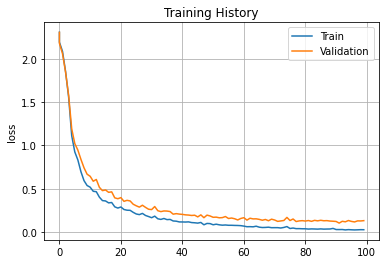

In [16]:
# Visualization of training history
pt_teacher.plot_training_history(metric="accuracy")
pt_teacher.plot_training_history(metric="loss")

## Teaching student model

In [ ]:
# Student model and performance tracker initialization
m_student_n = mdl.get_model(DATASET).to(DEVICE)
pt_student_n = hlp.PerfTracker(m_student_n, dl_dict, CRITERION, meta["n_class"], None, ID="Normal (s=1)")

#Knowledge distillation
for r in range(ROUNDS):
    # Blind learning (creation of input/output pairs)
    X = hlp.generate_data(dimensions=(RANDOM_SAMPLES, *meta["in_dimension"]), generator="normal").to(DEVICE)  
    
    m_teacher.eval()
    with torch.no_grad():
        Y = m_teacher(X)    
    ds_kd = hlp.CustomDataset(X, Y)
    dl_kd = hlp.ds_to_dl(ds_kd, batch_size=BATCH_SIZE_KD)
    
    # Blind learning (knowledge diffusion)
    optimizer = torch.optim.Adam(m_student_n.parameters())
    
    m_student_n.eval() #Should this be? maybe the dropout hinders the effect of KD
    for e in range(EPOCHS_PER_ROUND_KD):
        for x_kd, y_kd in dl_kd:
            optimizer.zero_grad()
            y_kd_pers = m_student_n(x_kd)
            loss = CRITERION_KD(y_kd_pers, y_kd)
            loss.backward()
            optimizer.step()
        
        #Tracking performance
        if r % N_EVAL == 0:
            perf = pt_student_n.new_eval(index=r)
            print("\rRound {}/{} (Train acc.: {} | Validation acc.: {})".format(r+1, ROUNDS, perf["Train"]["accuracy"], perf["Validation"]["accuracy"]), end=50*" ")
        else:
            print("\rRound {}/{}.".format(r+1, ROUNDS), end=50*" ")

In [110]:
m_student_n10 = mdl.get_model(DATASET).to(DEVICE)
pt_student_n10 = hlp.PerfTracker(m_student_n10, dl_dict, CRITERION, meta["n_class"], None, ID="Normal (s=10)")

#Knowledge distillation
for r in range(ROUNDS):
    # Blind learning (creation of input/output pairs)
    X = 10 * hlp.generate_data(dimensions=(RANDOM_SAMPLES, *meta["in_dimension"]), generator="normal").to(DEVICE)  
    
    m_teacher.eval()
    with torch.no_grad():
        Y = m_teacher(X)    
    ds_kd = hlp.CustomDataset(X, Y)
    dl_kd = hlp.ds_to_dl(ds_kd, batch_size=BATCH_SIZE_KD)
    
    # Blind learning (knowledge diffusion)
    optimizer = torch.optim.Adam(m_student_n10.parameters())    
    
    m_student_n10.eval() #Should this be? maybe the dropout hinders the effect of KD
    for e in range(EPOCHS_PER_ROUND_KD):
        for x_kd, y_kd in dl_kd:
            optimizer.zero_grad()
            y_kd_pers = m_student_n10(x_kd)
            loss = CRITERION_KD(y_kd_pers, y_kd)
            loss.backward()
            optimizer.step()
        
        #Tracking performance
        if r % N_EVAL == 0:
            perf = pt_student_n10.new_eval(index=r)
            print("\rRound {}/{} (Train acc.: {} | Validation acc.: {})".format(r+1, ROUNDS, perf["Train"]["accuracy"], perf["Validation"]["accuracy"]), end=50*" ")
        else:
            print("\rRound {}/{}.".format(r+1, ROUNDS), end=50*" ")

Round 200/200 (Train acc.: 0.8155 | Validation acc.: 0.768)                                                  

In [112]:
m_student_dl = mdl.get_model(DATASET).to(DEVICE)
pt_student_dl = hlp.PerfTracker(m_student_dl, dl_dict, CRITERION, meta["n_class"], None, ID="Normal (s=10)")

#Knowledge distillation
for r in range(ROUNDS):
    # Blind learning (creation of input/output pairs)
    X = hlp.generate_data(dimensions=(RANDOM_SAMPLES, *meta["in_dimension"]), generator="dead_leaves").to(DEVICE)  
    
    m_teacher.eval()
    with torch.no_grad():
        Y = m_teacher(X)    
    ds_kd = hlp.CustomDataset(X, Y)
    dl_kd = hlp.ds_to_dl(ds_kd, batch_size=BATCH_SIZE_KD)
    
    # Blind learning (knowledge diffusion)
    optimizer = torch.optim.Adam(m_student_dl.parameters())    
    
    m_student_dl.eval() #Should this be? maybe the dropout hinders the effect of KD
    for e in range(EPOCHS_PER_ROUND_KD):
        for x_kd, y_kd in dl_kd:
            optimizer.zero_grad()
            y_kd_pers = m_student_dl(x_kd)
            loss = CRITERION_KD(y_kd_pers, y_kd)
            loss.backward()
            optimizer.step()
        
        #Tracking performance
        if r % N_EVAL == 0:
            perf = pt_student_dl.new_eval(index=r)
            print("\rRound {}/{} (Train acc.: {} | Validation acc.: {})".format(r+1, ROUNDS, perf["Train"]["accuracy"], perf["Validation"]["accuracy"]), end=50*" ")
        else:
            print("\rRound {}/{}.".format(r+1, ROUNDS), end=50*" ")

Round 200/200 (Train acc.: 0.8965 | Validation acc.: 0.864)                                                  

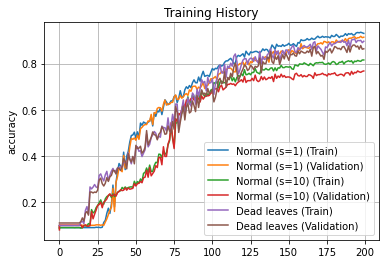

In [114]:
hlp.plot_global_training_history([pt_student_n, pt_student_n10, pt_student_dl], metric="accuracy")

## Visualize outputs

In [ ]:
with torch.no_grad():
    m = m_teacher
    x, x_hl = m(train_input, True)
    xn, xn_hl = m(hlp.generate_data(train_input.shape, "normal"), True)
    xn10, xn10_hl = m(10 * hlp.generate_data(train_input.shape, "normal"), True)
    xu, xu_hl = m(hlp.generate_data(train_input.shape, "uniform"), True)
    xdl, xdl_hl = m(hlp.generate_data(train_input.shape, "dead_leaves"), True)



In [ ]:
x_df = pd.DataFrame(x.numpy())
df_label = x_df
x_df["Data"] = "Real"
xn_df = pd.DataFrame(xn.numpy())
xn_df["Data"] = "Normal"
xn10_df = pd.DataFrame(xn10.numpy())
xn10_df["Data"] = "Normal (s=10)"
xu_df = pd.DataFrame(xu.numpy())
xu_df["Data"] = "Uniform"
xdl_df = pd.DataFrame(xdl.numpy())
xdl_df["Data"] = "Dead leaves"

df = pd.concat([x_df, xn_df, xn10_df], axis=0, ignore_index=True)

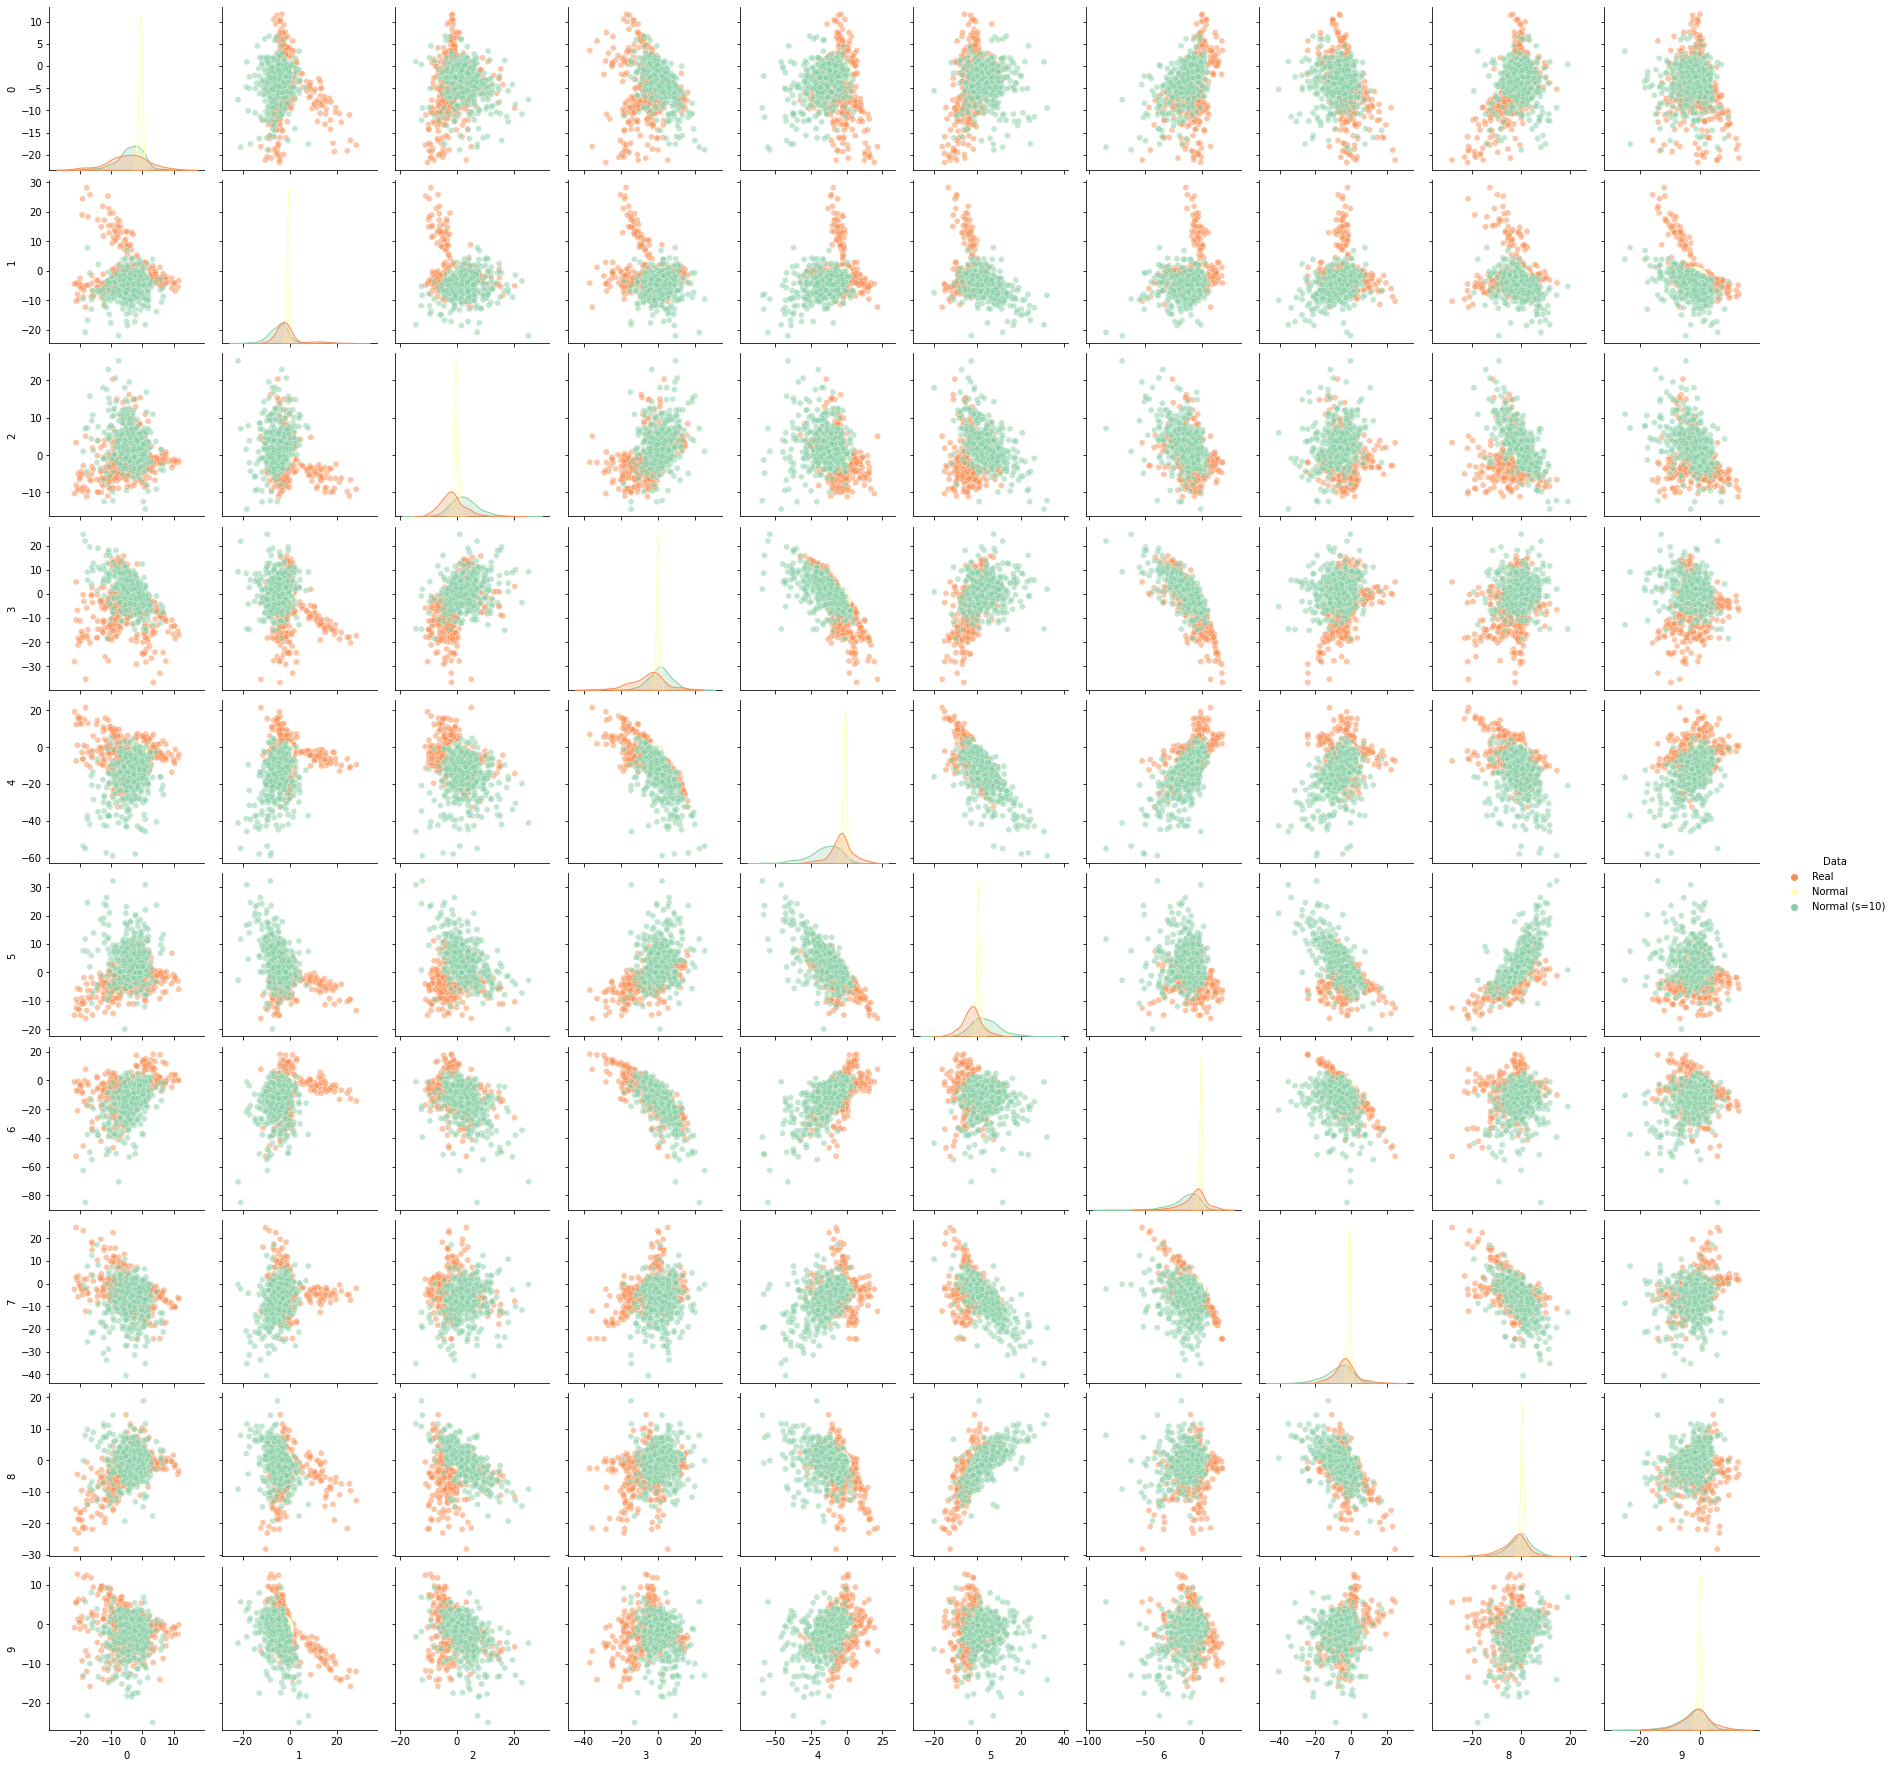

In [ ]:
sns.pairplot(df, hue="Data", plot_kws={"alpha":0.5}, palette="Spectral")

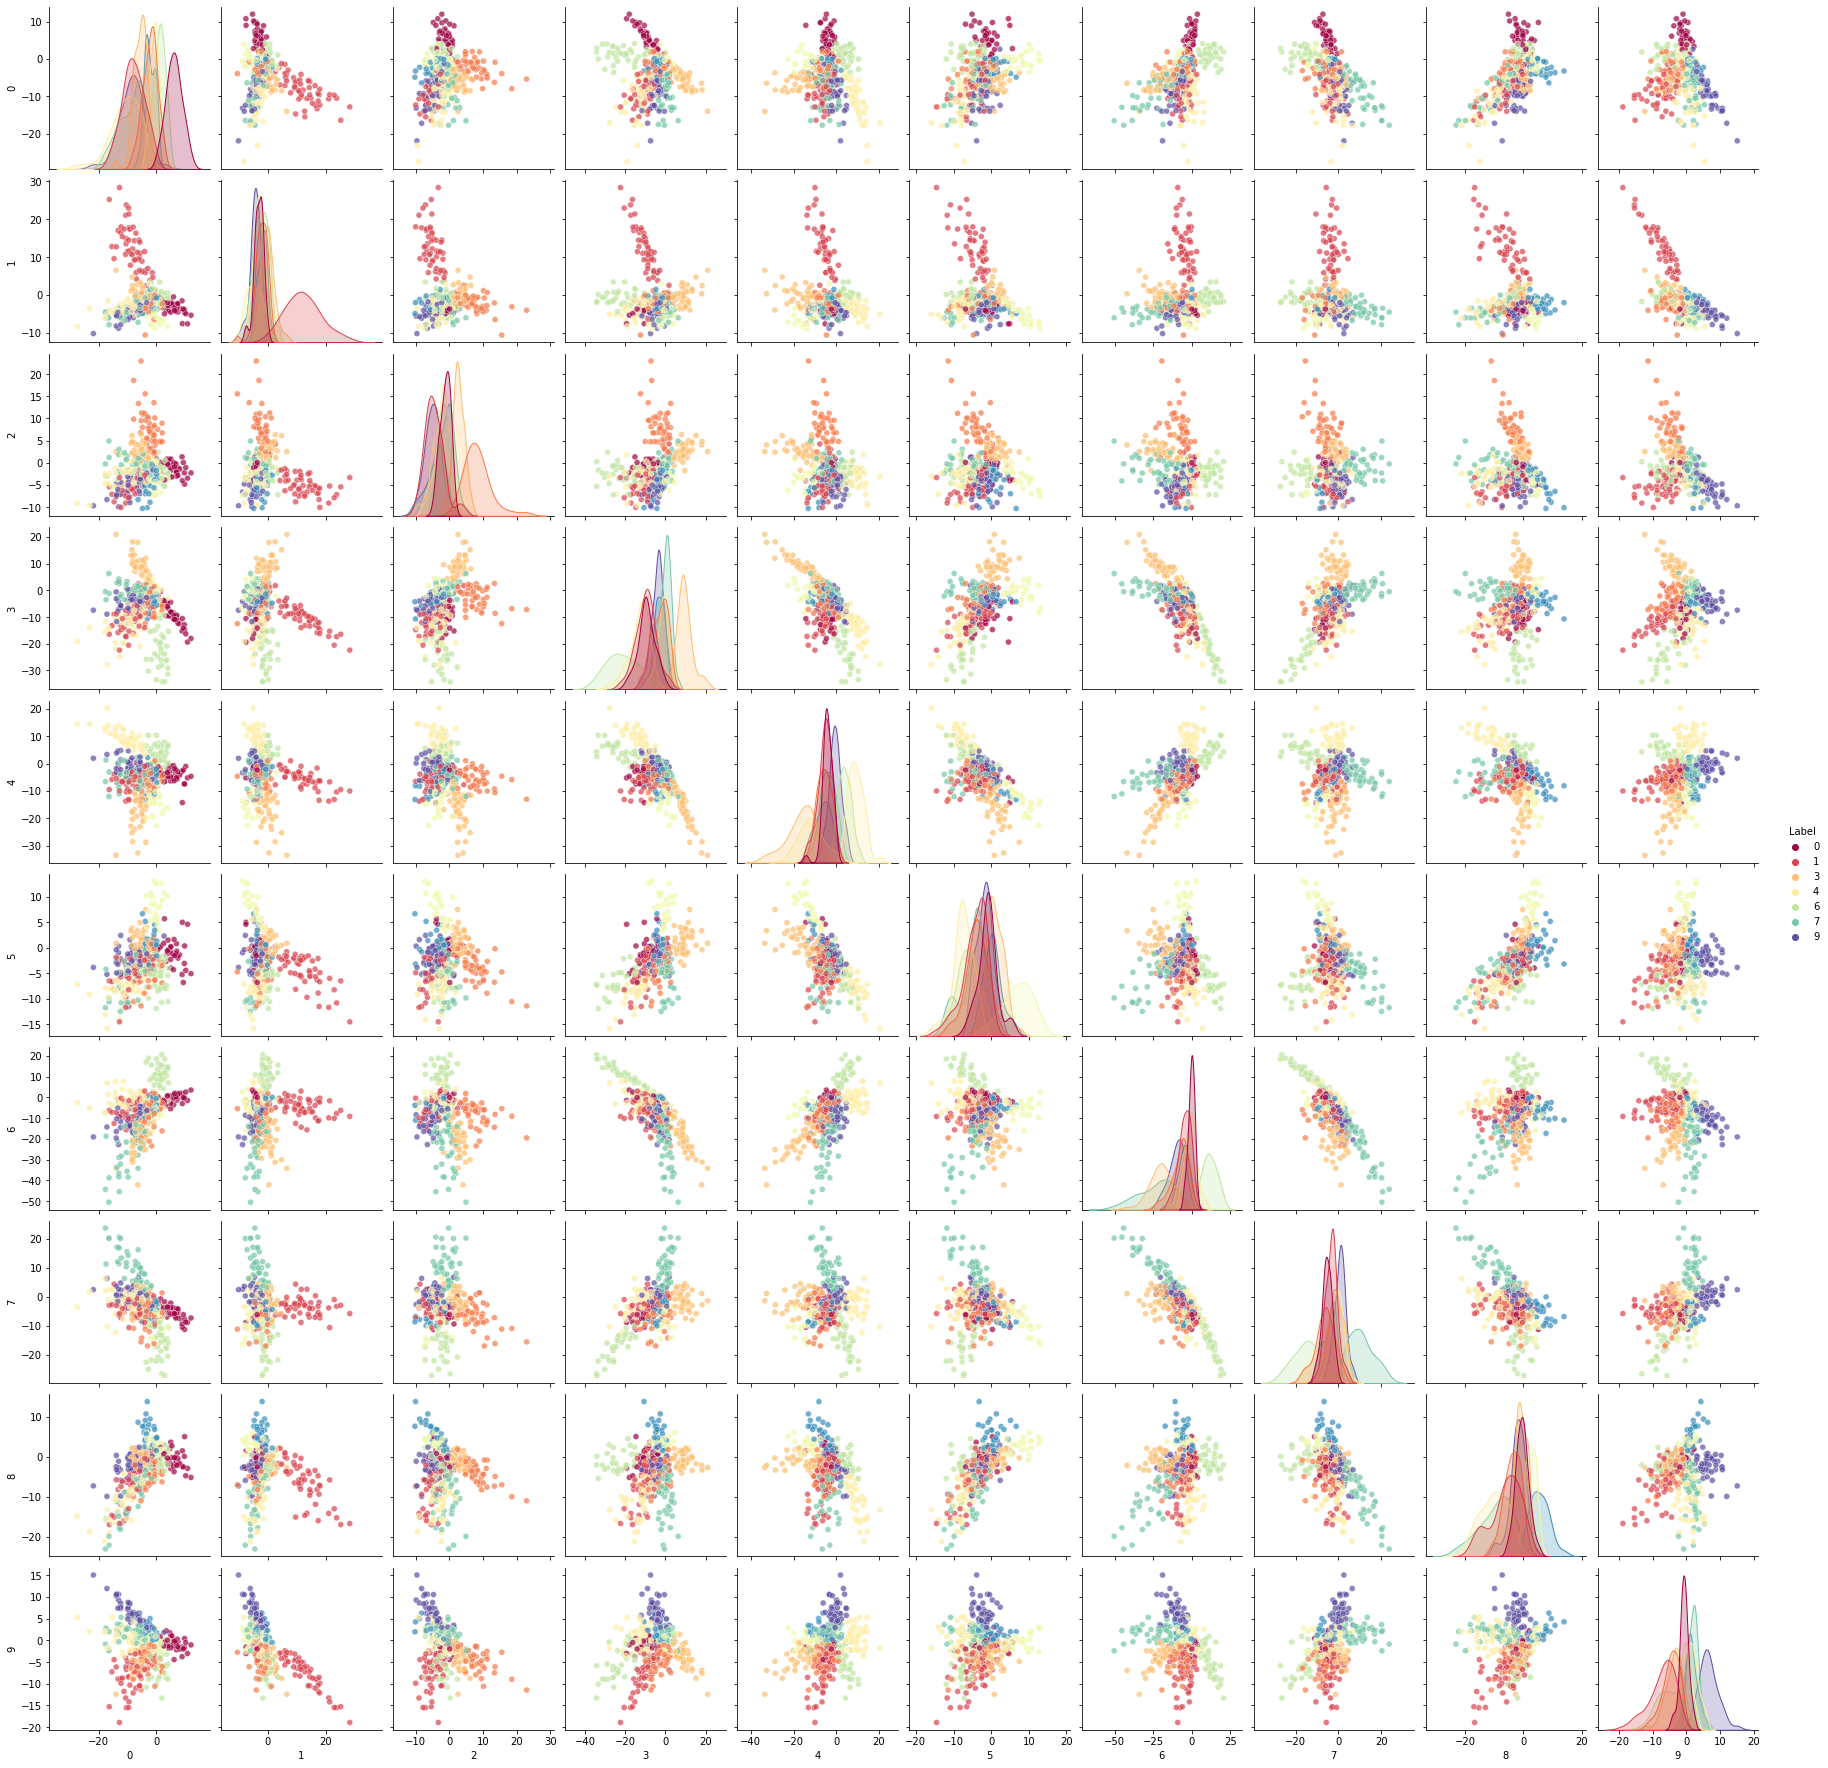

In [ ]:
df_label["Label"] = train_target.numpy()
sns.pairplot(df_label, hue="Label", plot_kws={"alpha":0.7}, palette="Spectral")

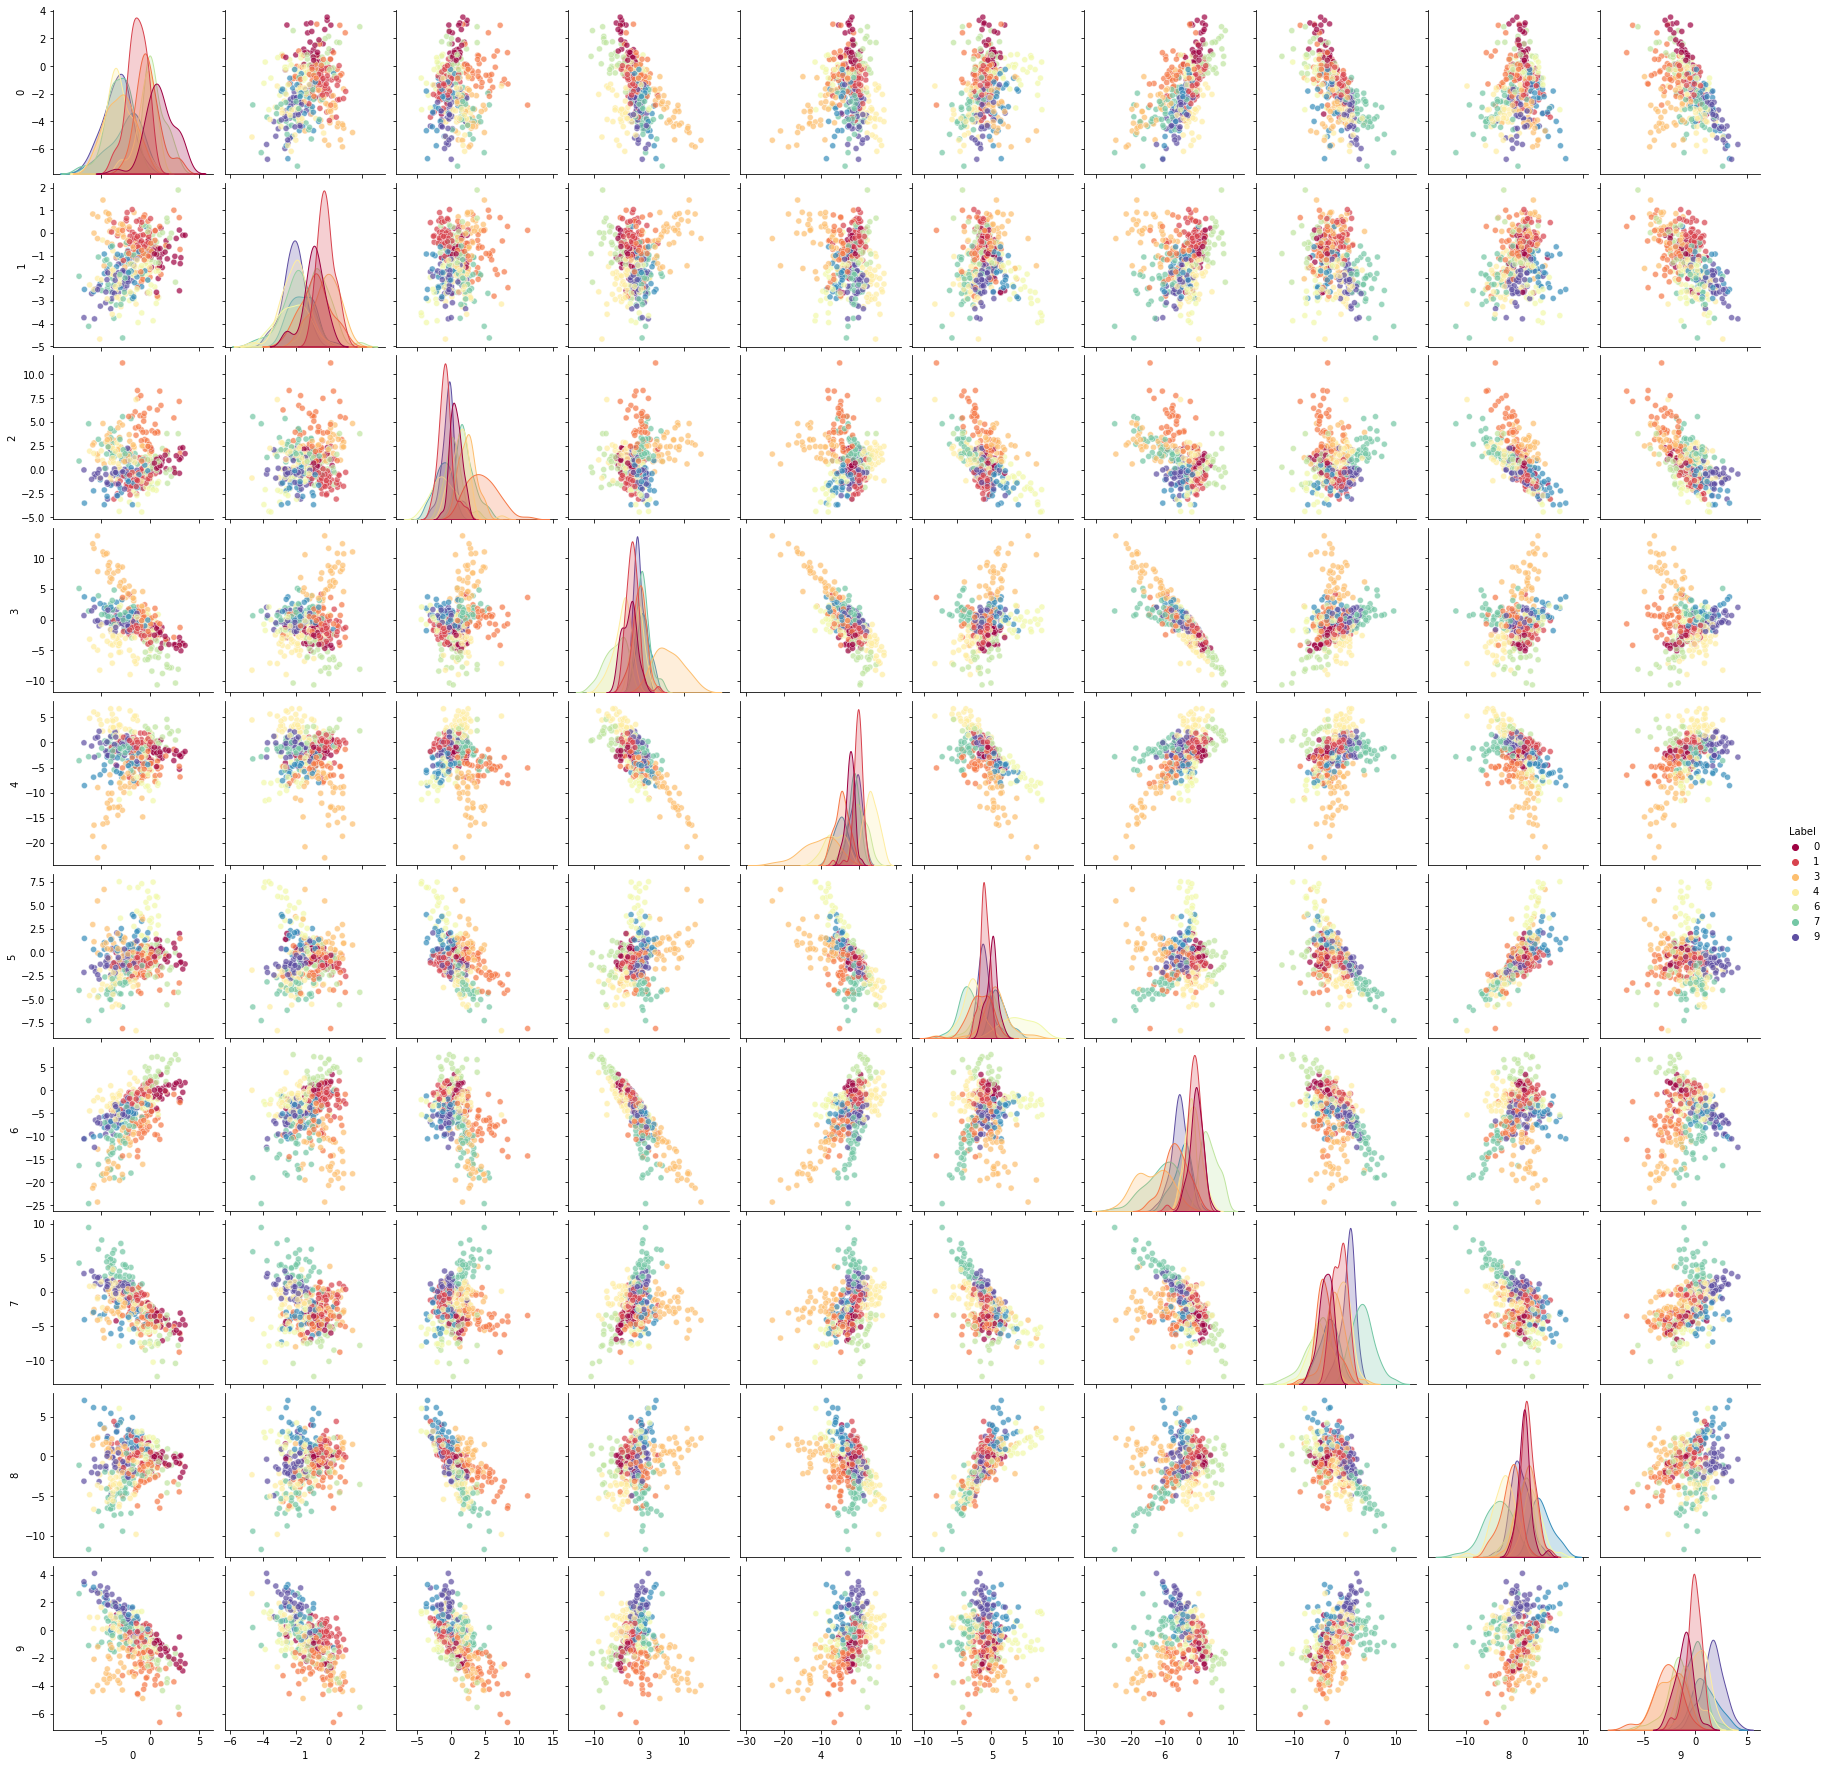

In [ ]:
df_label["Label"] = train_target.numpy()
sns.pairplot(df_label, hue="Label", plot_kws={"alpha":0.7}, palette="Spectral")